# 🧹 Data Cleaning and Preprocessing
### APS Failure Dataset - Class Imbalance Preprocessing Pipeline

---

### 🎯 **Notebook Overview**
This notebook implements comprehensive data preprocessing for the severely imbalanced APS failure dataset. We'll create a robust preprocessing pipeline that handles missing values, feature scaling, and prepares the data for class imbalance techniques.

### 📋 **Processing Steps**
1. **Data Loading and Initial Setup**
2. **Missing Values Handling**
3. **Feature Engineering and Selection**
4. **Data Scaling and Normalization**
5. **Train-Test Split with Stratification**
6. **Data Validation and Quality Checks**
7. **Preprocessing Pipeline Testing**

---

In [1]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
import joblib
import os
from datetime import datetime

In [2]:
#

# 🎨 Set Style and Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# 📊 Configure Plotting Parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 📁 Create directories for artifacts
os.makedirs('artifacts/data_transformation', exist_ok=True)
os.makedirs('artifacts/preprocessors', exist_ok=True)

print("✅ Libraries imported and directories created successfully!")
print(f"📅 Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported and directories created successfully!
📅 Processing Date: 2025-08-22 19:53:12


In [ ]:
# PATHS
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

In [21]:
os.makedirs('artifacts/preprocessors', exist_ok=True)
os.makedirs('artifacts/data_transformation', exist_ok=True)

## 1️⃣ Data Loading and Initial Setup

Load the dataset and perform initial data assessment.

In [3]:
# 📁 Load Dataset
print("🔄 Loading APS Failure Training Dataset...")
data = pd.read_csv('aps_failure_training_set.csv', na_values=['na'])

print(f"✅ Dataset loaded successfully!")
print(f"📏 Original Dataset Shape: {data.shape}")
print(f"💾 Memory Usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 🎯 Separate features and target
X = data.drop('class', axis=1)
y = data['class']

print(f"\n🎯 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"🎯 Target classes: {y.unique()}")
print(f"🎯 Class distribution: {y.value_counts().to_dict()}")

🔄 Loading APS Failure Training Dataset...
✅ Dataset loaded successfully!
📏 Original Dataset Shape: (60000, 171)
💾 Memory Usage: 81.25 MB

🎯 Features shape: (60000, 170)
🎯 Target shape: (60000,)
🎯 Target classes: ['neg' 'pos']
🎯 Class distribution: {'neg': 59000, 'pos': 1000}


In [4]:
# 📊 Initial Data Quality Assessment
print("📊 INITIAL DATA QUALITY ASSESSMENT")
print("="*50)

# Missing values analysis
missing_counts = X.isnull().sum()
missing_percentages = (missing_counts / len(X)) * 100
missing_info = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Count', ascending=False)

columns_with_missing = missing_info[missing_info['Missing_Count'] > 0]

print(f"📊 Total features: {len(X.columns)}")
print(f"🔍 Features with missing values: {len(columns_with_missing)}")
print(f"✅ Features without missing values: {len(X.columns) - len(columns_with_missing)}")

if len(columns_with_missing) > 0:
    print(f"\n🔍 Top 10 features with most missing values:")
    display(columns_with_missing.head(10))

# Data types analysis
print(f"\n📊 Data Types Distribution:")
print(X.dtypes.value_counts())

# Basic statistics
print(f"\n📈 Basic Statistics:")
print(f"  • Min value across all features: {X.min().min():.2e}")
print(f"  • Max value across all features: {X.max().max():.2e}")
print(f"  • Mean of feature means: {X.mean().mean():.2e}")
print(f"  • Mean of feature std: {X.std().mean():.2e}")

📊 INITIAL DATA QUALITY ASSESSMENT
📊 Total features: 170
🔍 Features with missing values: 169
✅ Features without missing values: 1

🔍 Top 10 features with most missing values:


,Missing_Count,Missing_Percentage
br_000,49264,82.106667
bq_000,48722,81.203333
bp_000,47740,79.566667
bo_000,46333,77.221667
ab_000,46329,77.215000
cr_000,46329,77.215000
bn_000,44009,73.348333
bm_000,39549,65.915000
bl_000,27277,45.461667
bk_000,23034,38.390000



📊 Data Types Distribution:
float64    169
int64        1
Name: count, dtype: int64

📈 Basic Statistics:
  • Min value across all features: 0.00e+00
  • Max value across all features: 8.58e+09
  • Mean of feature means: 2.69e+06
  • Mean of feature std: 7.58e+06


## 2️⃣ Missing Values Handling

Implement comprehensive missing values handling strategy.

In [5]:
# 🔧 Missing Values Handling Strategy
print("🔧 MISSING VALUES HANDLING STRATEGY")
print("="*50)

# Analyze missing data patterns
def analyze_missing_patterns(df):
    """
    Analyze missing data patterns in the dataset
    """
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    # Categorize columns by missing percentage
    no_missing = missing_percent[missing_percent == 0].index.tolist()
    low_missing = missing_percent[(missing_percent > 0) & (missing_percent <= 10)].index.tolist()
    medium_missing = missing_percent[(missing_percent > 10) & (missing_percent <= 50)].index.tolist()
    high_missing = missing_percent[missing_percent > 50].index.tolist()
    
    return {
        'no_missing': no_missing,
        'low_missing': low_missing,
        'medium_missing': medium_missing,
        'high_missing': high_missing,
        'missing_percent': missing_percent
    }

# Analyze patterns
missing_analysis = analyze_missing_patterns(X)

print(f"📊 Missing Data Pattern Analysis:")
print(f"  • No missing values: {len(missing_analysis['no_missing'])} features")
print(f"  • Low missing (≤10%): {len(missing_analysis['low_missing'])} features")
print(f"  • Medium missing (10-50%): {len(missing_analysis['medium_missing'])} features")
print(f"  • High missing (>50%): {len(missing_analysis['high_missing'])} features")

# Display high missing features
if len(missing_analysis['high_missing']) > 0:
    print(f"\n⚠️ Features with >50% missing values:")
    high_missing_info = missing_analysis['missing_percent'][missing_analysis['high_missing']].sort_values(ascending=False)
    for feature, pct in high_missing_info.items():
        print(f"    {feature}: {pct:.1f}%")

🔧 MISSING VALUES HANDLING STRATEGY
📊 Missing Data Pattern Analysis:
  • No missing values: 1 features
  • Low missing (≤10%): 141 features
  • Medium missing (10-50%): 20 features
  • High missing (>50%): 8 features

⚠️ Features with >50% missing values:
    br_000: 82.1%
    bq_000: 81.2%
    bp_000: 79.6%
    bo_000: 77.2%
    ab_000: 77.2%
    cr_000: 77.2%
    bn_000: 73.3%
    bm_000: 65.9%


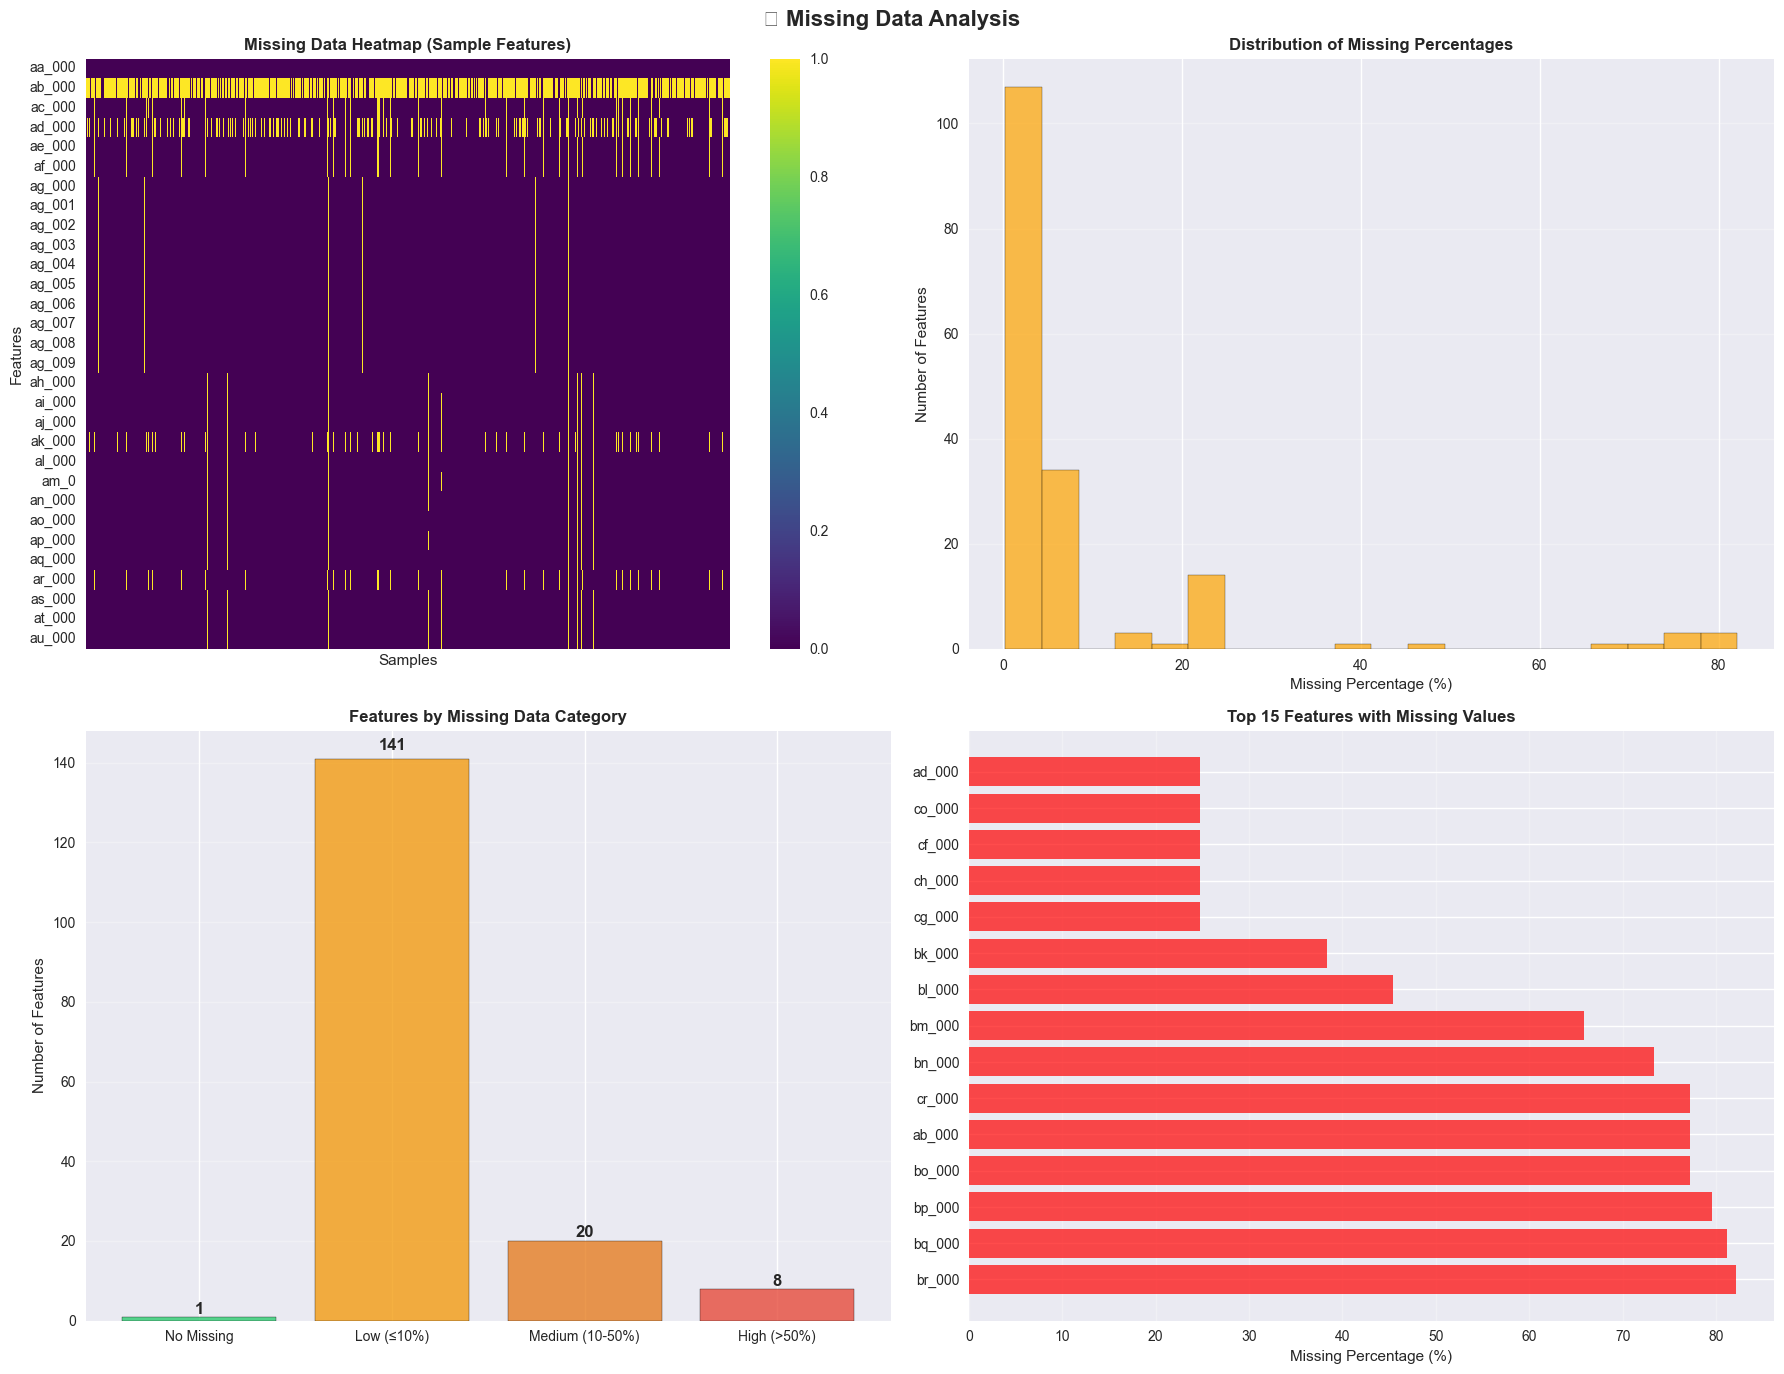

💾 Missing data analysis saved to: artifacts/missing_data_analysis.png


In [7]:
# 📊 Visualize Missing Data Patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🔍 Missing Data Analysis', fontsize=16, fontweight='bold')

# 1. Missing data heatmap (sample of columns)
ax1 = axes[0, 0]
sample_cols = X.columns[:30]  # First 30 columns for visualization
missing_matrix = X[sample_cols].isnull()
sns.heatmap(missing_matrix.T, cbar=True, ax=ax1, cmap='viridis', 
           yticklabels=True, xticklabels=False)
ax1.set_title('Missing Data Heatmap (Sample Features)', fontweight='bold')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Features')

# 2. Missing percentage distribution
ax2 = axes[0, 1]
missing_pcts = missing_analysis['missing_percent'][missing_analysis['missing_percent'] > 0]
ax2.hist(missing_pcts, bins=20, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Missing Percentage (%)')
ax2.set_ylabel('Number of Features')
ax2.set_title('Distribution of Missing Percentages', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Missing data by category
ax3 = axes[1, 0]
categories = ['No Missing', 'Low (≤10%)', 'Medium (10-50%)', 'High (>50%)']
counts = [len(missing_analysis['no_missing']), 
          len(missing_analysis['low_missing']),
          len(missing_analysis['medium_missing']), 
          len(missing_analysis['high_missing'])]
colors = ['#2ECC71', '#F39C12', '#E67E22', '#E74C3C']

bars = ax3.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Number of Features')
ax3.set_title('Features by Missing Data Category', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. Top missing features
ax4 = axes[1, 1]
if len(columns_with_missing) > 0:
    top_missing = columns_with_missing.head(15)
    ax4.barh(range(len(top_missing)), top_missing['Missing_Percentage'], 
             color='red', alpha=0.7)
    ax4.set_yticks(range(len(top_missing)))
    ax4.set_yticklabels(top_missing.index)
    ax4.set_xlabel('Missing Percentage (%)')
    ax4.set_title('Top 15 Features with Missing Values', fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center',
             transform=ax4.transAxes, fontsize=14, fontweight='bold')
    ax4.set_title('Missing Values Status', fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Missing data analysis saved to: artifacts/missing_data_analysis.png")

In [8]:
# 🔧 Implement Missing Values Handling
print("🔧 IMPLEMENTING MISSING VALUES HANDLING")
print("="*50)

# Create a copy of the data for processing
X_processed = X.copy()

# Strategy: Use median imputation for numeric features
# This is robust to outliers and works well with skewed distributions

print("📊 Before imputation:")
print(f"  • Total missing values: {X_processed.isnull().sum().sum():,}")
print(f"  • Features with missing values: {(X_processed.isnull().sum() > 0).sum()}")

# Apply median imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_processed),
    columns=X_processed.columns,
    index=X_processed.index
)

print(f"\n📊 After imputation:")
print(f"  • Total missing values: {X_imputed.isnull().sum().sum():,}")
print(f"  • Features with missing values: {(X_imputed.isnull().sum() > 0).sum()}")

# Save the imputer
joblib.dump(imputer, 'artifacts/preprocessors/imputer.pkl')
print(f"\n💾 Imputer saved to: artifacts/preprocessors/imputer.pkl")

# Verify no missing values remain
if X_imputed.isnull().sum().sum() == 0:
    print("✅ All missing values successfully handled!")
else:
    print("⚠️ Some missing values remain - investigation needed")

🔧 IMPLEMENTING MISSING VALUES HANDLING
📊 Before imputation:
  • Total missing values: 850,015
  • Features with missing values: 169

📊 After imputation:
  • Total missing values: 0
  • Features with missing values: 0

💾 Imputer saved to: artifacts/preprocessors/imputer.pkl
✅ All missing values successfully handled!


## 3️⃣ Feature Engineering and Selection

Remove low-variance features and perform feature engineering.

In [9]:
# 🔧 Feature Engineering and Selection
print("🔧 FEATURE ENGINEERING AND SELECTION")
print("="*50)

# 1. Identify constant features (zero variance)
print("🔍 Identifying constant and low-variance features...")

# Check for constant features
constant_features = []
for col in X_imputed.columns:
    if X_imputed[col].nunique() <= 1:
        constant_features.append(col)

print(f"📊 Constant features found: {len(constant_features)}")
if len(constant_features) > 0:
    print(f"  • Features: {constant_features[:10]}...")  # Show first 10

# 2. Remove low-variance features
# Use VarianceThreshold to remove features with very low variance
variance_threshold = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
X_variance_filtered = variance_threshold.fit_transform(X_imputed)

# Get feature names after variance filtering
variance_feature_mask = variance_threshold.get_support()
selected_features = X_imputed.columns[variance_feature_mask].tolist()
removed_features = X_imputed.columns[~variance_feature_mask].tolist()

print(f"\n📊 Variance-based feature selection:")
print(f"  • Original features: {len(X_imputed.columns)}")
print(f"  • Features kept: {len(selected_features)}")
print(f"  • Features removed: {len(removed_features)}")

# Create DataFrame with selected features
X_selected = pd.DataFrame(
    X_variance_filtered,
    columns=selected_features,
    index=X_imputed.index
)

# Save variance threshold selector
joblib.dump(variance_threshold, 'artifacts/preprocessors/variance_selector.pkl')
print(f"\n💾 Variance selector saved to: artifacts/preprocessors/variance_selector.pkl")

🔧 FEATURE ENGINEERING AND SELECTION
🔍 Identifying constant and low-variance features...
📊 Constant features found: 1
  • Features: ['cd_000']...

📊 Variance-based feature selection:
  • Original features: 170
  • Features kept: 168
  • Features removed: 2

💾 Variance selector saved to: artifacts/preprocessors/variance_selector.pkl


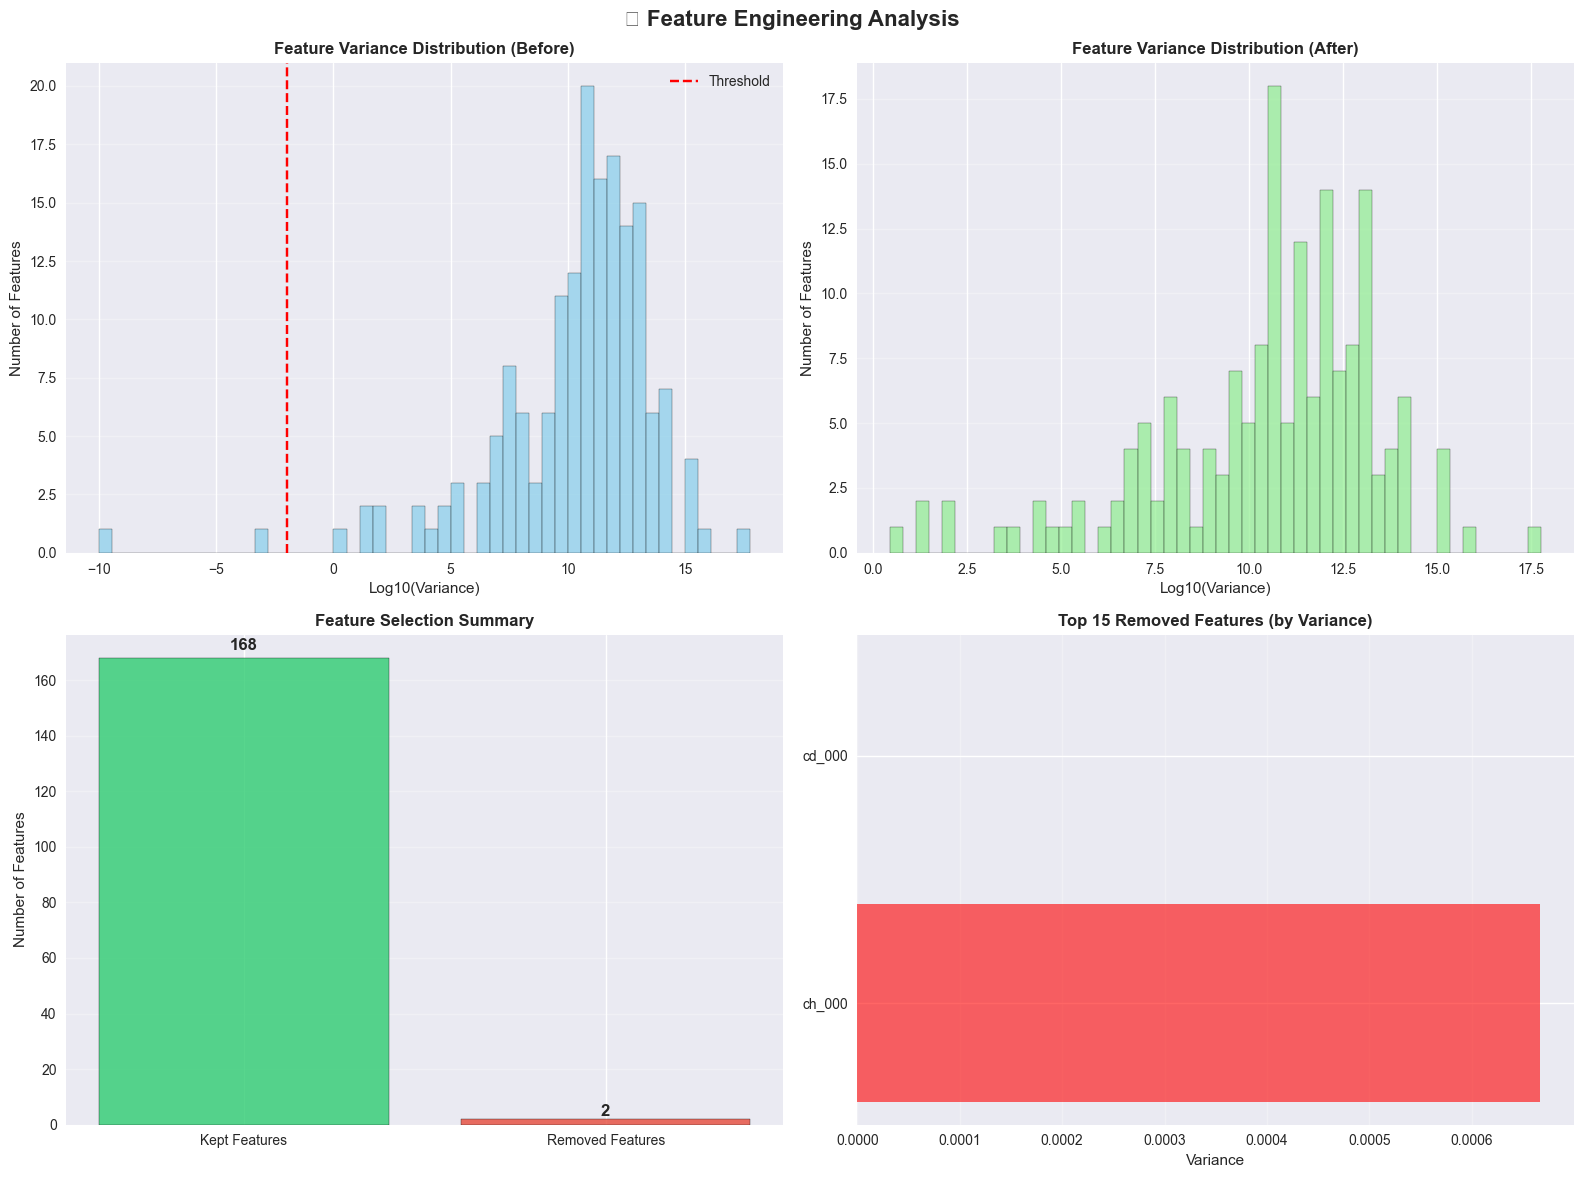

💾 Feature engineering analysis saved to: artifacts/feature_engineering_analysis.png


In [10]:
# 📊 Feature Selection Analysis Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔧 Feature Engineering Analysis', fontsize=16, fontweight='bold')

# 1. Feature variance distribution (before filtering)
ax1 = axes[0, 0]
variances = X_imputed.var()
ax1.hist(np.log10(variances + 1e-10), bins=50, color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Log10(Variance)')
ax1.set_ylabel('Number of Features')
ax1.set_title('Feature Variance Distribution (Before)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axvline(np.log10(0.01), color='red', linestyle='--', label='Threshold')
ax1.legend()

# 2. Feature variance distribution (after filtering)
ax2 = axes[0, 1]
selected_variances = X_selected.var()
ax2.hist(np.log10(selected_variances + 1e-10), bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Log10(Variance)')
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Variance Distribution (After)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Feature selection summary
ax3 = axes[1, 0]
categories = ['Kept Features', 'Removed Features']
counts = [len(selected_features), len(removed_features)]
colors = ['#2ECC71', '#E74C3C']

bars = ax3.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Number of Features')
ax3.set_title('Feature Selection Summary', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Sample of removed features (if any)
ax4 = axes[1, 1]
if len(removed_features) > 0:
    # Show variance of removed features
    removed_variances = X_imputed[removed_features].var().sort_values(ascending=False)
    top_removed = removed_variances.head(15)
    
    ax4.barh(range(len(top_removed)), top_removed.values, color='red', alpha=0.6)
    ax4.set_yticks(range(len(top_removed)))
    ax4.set_yticklabels(top_removed.index)
    ax4.set_xlabel('Variance')
    ax4.set_title('Top 15 Removed Features (by Variance)', fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Features Removed', ha='center', va='center',
             transform=ax4.transAxes, fontsize=14, fontweight='bold')
    ax4.set_title('Removed Features', fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/feature_engineering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Feature engineering analysis saved to: artifacts/feature_engineering_analysis.png")

## 4️⃣ Data Scaling and Normalization

Apply feature scaling to normalize the data range.

In [11]:
# 🔧 Data Scaling and Normalization
print("🔧 DATA SCALING AND NORMALIZATION")
print("="*50)

# Analyze feature scales before scaling
print("📊 Feature scale analysis (before scaling):")
feature_stats = X_selected.describe()
print(f"  • Min value: {feature_stats.loc['min'].min():.2e}")
print(f"  • Max value: {feature_stats.loc['max'].max():.2e}")
print(f"  • Mean of means: {feature_stats.loc['mean'].mean():.2e}")
print(f"  • Mean of std: {feature_stats.loc['std'].mean():.2e}")

# Apply StandardScaler (z-score normalization)
# This is preferred for algorithms like SVM and Logistic Regression
print(f"\n🔄 Applying StandardScaler...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

# Analyze feature scales after scaling
print("\n📊 Feature scale analysis (after scaling):")
scaled_stats = X_scaled.describe()
print(f"  • Min value: {scaled_stats.loc['min'].min():.2e}")
print(f"  • Max value: {scaled_stats.loc['max'].max():.2e}")
print(f"  • Mean of means: {scaled_stats.loc['mean'].mean():.2e}")
print(f"  • Mean of std: {scaled_stats.loc['std'].mean():.2e}")

# Save the scaler
joblib.dump(scaler, 'artifacts/preprocessors/scaler.pkl')
print(f"\n💾 Scaler saved to: artifacts/preprocessors/scaler.pkl")

print("✅ Data scaling completed successfully!")

🔧 DATA SCALING AND NORMALIZATION
📊 Feature scale analysis (before scaling):
  • Min value: 0.00e+00
  • Max value: 8.58e+09
  • Mean of means: 2.58e+06
  • Mean of std: 7.42e+06

🔄 Applying StandardScaler...

📊 Feature scale analysis (after scaling):
  • Min value: -1.45e+00
  • Max value: 2.45e+02
  • Mean of means: 1.83e-18
  • Mean of std: 1.00e+00

💾 Scaler saved to: artifacts/preprocessors/scaler.pkl
✅ Data scaling completed successfully!


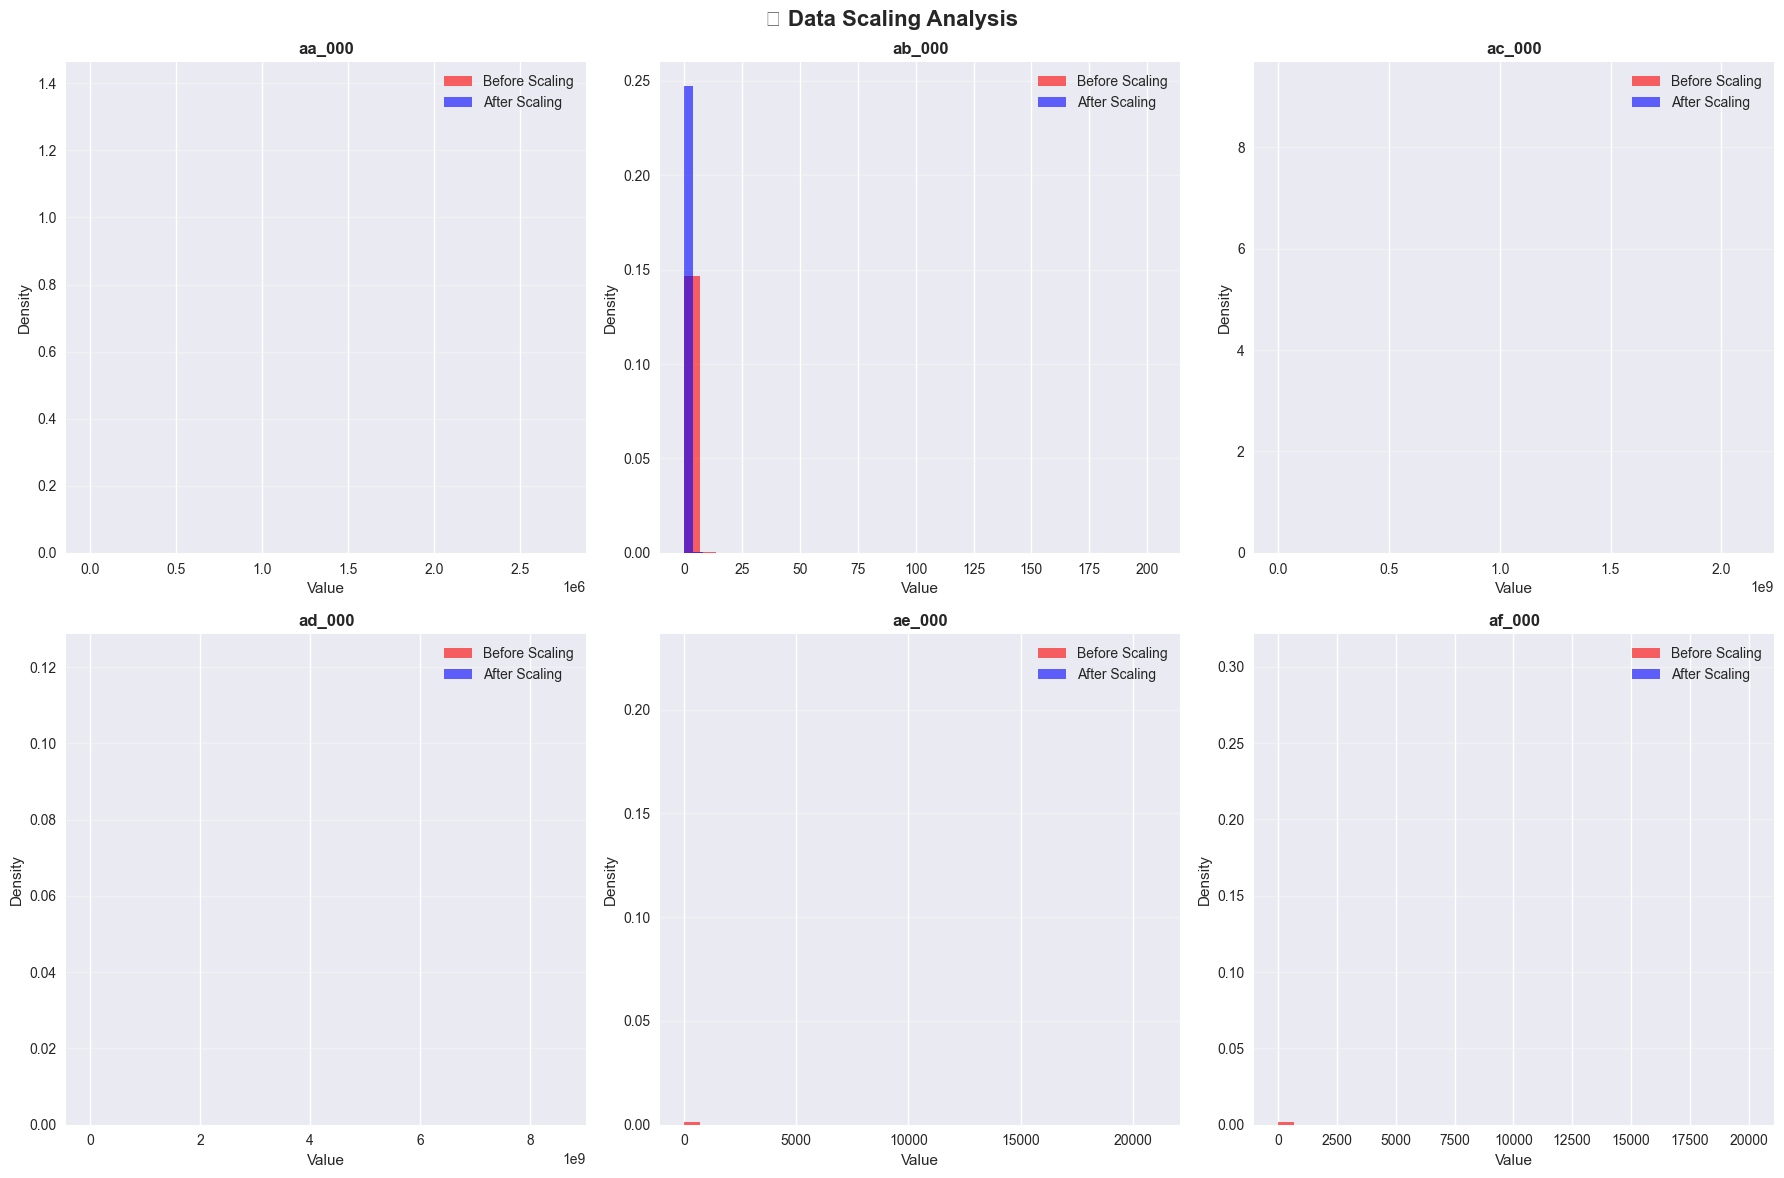

💾 Scaling analysis saved to: artifacts/scaling_analysis.png


In [14]:
# 📊 Scaling Analysis Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🔧 Data Scaling Analysis', fontsize=16, fontweight='bold')

# Select sample features for visualization
sample_features = X_selected.columns[:6]

for i, feature in enumerate(sample_features):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Plot before and after scaling
    ax.hist(X_selected[feature], bins=30, alpha=0.6, label='Before Scaling', 
           color='red', density=True)
    ax.hist(X_scaled[feature], bins=30, alpha=0.6, label='After Scaling', 
           color='blue', density=True)
    
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Scaling analysis saved to: artifacts/scaling_analysis.png")

## 5️⃣ Train-Test Split with Stratification

Split the data while maintaining class distribution.

In [15]:
# 🎯 Encode Target Variable
print("🎯 TARGET VARIABLE ENCODING")
print("="*30)

# Encode target labels: 'neg' -> 0, 'pos' -> 1
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"📊 Original target classes: {y.unique()}")
print(f"📊 Encoded target classes: {np.unique(y_encoded)}")
print(f"📊 Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Save label encoder
joblib.dump(label_encoder, 'artifacts/preprocessors/label_encoder.pkl')
print(f"💾 Label encoder saved to: artifacts/preprocessors/label_encoder.pkl")

🎯 TARGET VARIABLE ENCODING
📊 Original target classes: ['neg' 'pos']
📊 Encoded target classes: [0 1]
📊 Label mapping: {'neg': np.int64(0), 'pos': np.int64(1)}
💾 Label encoder saved to: artifacts/preprocessors/label_encoder.pkl


In [16]:
# 🔄 Train-Test Split with Stratification
print("🔄 TRAIN-TEST SPLIT WITH STRATIFICATION")
print("="*50)

# Perform stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"📊 Data split completed:")
print(f"  • Training set: {X_train.shape} features, {len(y_train)} samples")
print(f"  • Testing set: {X_test.shape} features, {len(y_test)} samples")

# Verify class distribution is maintained
train_class_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_class_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()

print(f"\n📊 Class distribution verification:")
print(f"  • Training set - Class 0: {train_class_dist[0]:.3f}, Class 1: {train_class_dist[1]:.3f}")
print(f"  • Testing set - Class 0: {test_class_dist[0]:.3f}, Class 1: {test_class_dist[1]:.3f}")

# Calculate class imbalance ratio
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

train_ratio = train_counts[0] / train_counts[1]
test_ratio = test_counts[0] / test_counts[1]

print(f"\n⚖️ Imbalance ratios:")
print(f"  • Training set: {train_ratio:.1f}:1")
print(f"  • Testing set: {test_ratio:.1f}:1")

if abs(train_ratio - test_ratio) < 0.5:
    print("✅ Class distribution successfully maintained across splits!")
else:
    print("⚠️ Class distribution varies between splits - check stratification")

🔄 TRAIN-TEST SPLIT WITH STRATIFICATION
📊 Data split completed:
  • Training set: (48000, 168) features, 48000 samples
  • Testing set: (12000, 168) features, 12000 samples

📊 Class distribution verification:
  • Training set - Class 0: 0.983, Class 1: 0.017
  • Testing set - Class 0: 0.983, Class 1: 0.017

⚖️ Imbalance ratios:
  • Training set: 59.0:1
  • Testing set: 59.0:1
✅ Class distribution successfully maintained across splits!


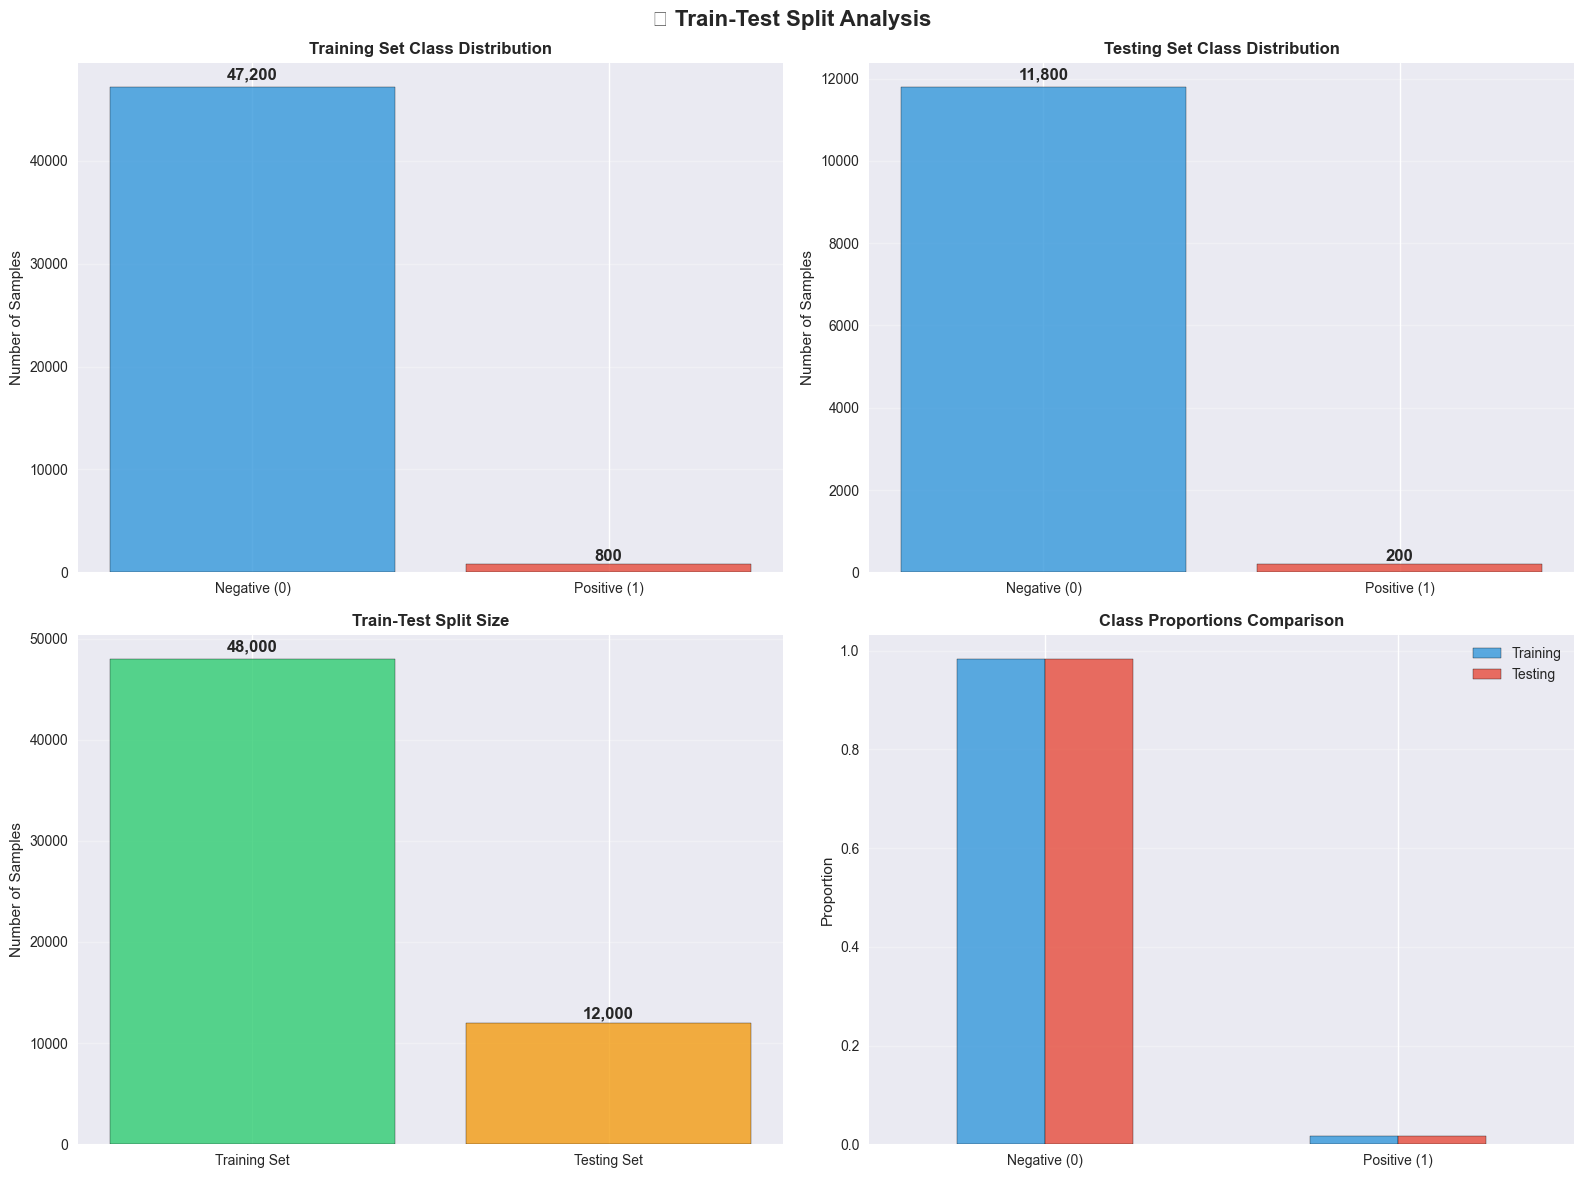

💾 Train-test split analysis saved to: artifacts/train_test_split_analysis.png


In [17]:
# 📊 Train-Test Split Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔄 Train-Test Split Analysis', fontsize=16, fontweight='bold')

# 1. Training set class distribution
ax1 = axes[0, 0]
train_class_counts = pd.Series(y_train).value_counts().sort_index()
bars1 = ax1.bar(['Negative (0)', 'Positive (1)'], train_class_counts.values, 
               color=['#3498DB', '#E74C3C'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Training Set Class Distribution', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars1, train_class_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 2. Testing set class distribution
ax2 = axes[0, 1]
test_class_counts = pd.Series(y_test).value_counts().sort_index()
bars2 = ax2.bar(['Negative (0)', 'Positive (1)'], test_class_counts.values, 
               color=['#3498DB', '#E74C3C'], alpha=0.8, edgecolor='black')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Testing Set Class Distribution', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars2, test_class_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 3. Split size comparison
ax3 = axes[1, 0]
split_sizes = [len(X_train), len(X_test)]
split_labels = ['Training Set', 'Testing Set']
colors = ['#2ECC71', '#F39C12']

bars3 = ax3.bar(split_labels, split_sizes, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Train-Test Split Size', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add size labels
for bar, size in zip(bars3, split_sizes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

# 4. Class proportion comparison
ax4 = axes[1, 1]
class_props = pd.DataFrame({
    'Training': train_class_dist.values,
    'Testing': test_class_dist.values
}, index=['Negative (0)', 'Positive (1)'])

class_props.plot(kind='bar', ax=ax4, color=['#3498DB', '#E74C3C'], 
                alpha=0.8, edgecolor='black')
ax4.set_ylabel('Proportion')
ax4.set_title('Class Proportions Comparison', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('artifacts/train_test_split_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Train-test split analysis saved to: artifacts/train_test_split_analysis.png")

## 6️⃣ Data Validation and Quality Checks

Perform final validation of the preprocessed data.

In [18]:
# ✅ Data Validation and Quality Checks
print("✅ DATA VALIDATION AND QUALITY CHECKS")
print("="*50)

def validate_processed_data(X_train, X_test, y_train, y_test):
    """
    Comprehensive validation of processed data
    """
    validation_results = {}
    
    # 1. Check for missing values
    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    validation_results['missing_values'] = train_missing + test_missing == 0
    
    # 2. Check data types
    train_numeric = X_train.select_dtypes(include=[np.number]).shape[1]
    validation_results['all_numeric'] = train_numeric == X_train.shape[1]
    
    # 3. Check feature consistency
    validation_results['feature_consistency'] = list(X_train.columns) == list(X_test.columns)
    
    # 4. Check scaling (mean close to 0, std close to 1)
    train_means = X_train.mean()
    train_stds = X_train.std()
    validation_results['proper_scaling'] = (
        abs(train_means.mean()) < 0.1 and 
        abs(train_stds.mean() - 1.0) < 0.1
    )
    
    # 5. Check class distribution preservation
    train_ratio = pd.Series(y_train).value_counts()[0] / pd.Series(y_train).value_counts()[1]
    test_ratio = pd.Series(y_test).value_counts()[0] / pd.Series(y_test).value_counts()[1]
    validation_results['class_distribution_preserved'] = abs(train_ratio - test_ratio) < 1.0
    
    # 6. Check for infinite values
    train_inf = np.isinf(X_train).sum().sum()
    test_inf = np.isinf(X_test).sum().sum()
    validation_results['no_infinite_values'] = train_inf + test_inf == 0
    
    return validation_results

# Run validation
validation_results = validate_processed_data(X_train, X_test, y_train, y_test)

print("🔍 Validation Results:")
for check, result in validation_results.items():
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"  • {check.replace('_', ' ').title()}: {status}")

# Overall validation score
total_checks = len(validation_results)
passed_checks = sum(validation_results.values())
validation_score = (passed_checks / total_checks) * 100

print(f"\n📊 Overall Validation Score: {validation_score:.1f}% ({passed_checks}/{total_checks} checks passed)")

if validation_score == 100:
    print("🎉 All validation checks passed! Data is ready for modeling.")
elif validation_score >= 80:
    print("✅ Most validation checks passed. Minor issues may need attention.")
else:
    print("⚠️ Several validation checks failed. Review preprocessing steps.")

✅ DATA VALIDATION AND QUALITY CHECKS
🔍 Validation Results:
  • Missing Values: ✅ PASS
  • All Numeric: ✅ PASS
  • Feature Consistency: ✅ PASS
  • Proper Scaling: ✅ PASS
  • Class Distribution Preserved: ✅ PASS
  • No Infinite Values: ✅ PASS

📊 Overall Validation Score: 100.0% (6/6 checks passed)
🎉 All validation checks passed! Data is ready for modeling.


In [19]:
# 📊 Final Data Summary
print("📊 FINAL PREPROCESSED DATA SUMMARY")
print("="*50)

print(f"🎯 Final Dataset Characteristics:")
print(f"  • Total samples: {len(X_scaled):,}")
print(f"  • Total features: {X_scaled.shape[1]}")
print(f"  • Training samples: {len(X_train):,} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"  • Testing samples: {len(X_test):,} ({len(X_test)/len(X_scaled)*100:.1f}%)")

print(f"\n🔧 Preprocessing Steps Applied:")
print(f"  • ✅ Missing values imputed (median strategy)")
print(f"  • ✅ Low-variance features removed ({len(removed_features)} features)")
print(f"  • ✅ Features scaled (StandardScaler)")
print(f"  • ✅ Target variable encoded (LabelEncoder)")
print(f"  • ✅ Stratified train-test split (80/20)")

print(f"\n📁 Saved Preprocessing Objects:")
print(f"  • artifacts/preprocessors/imputer.pkl")
print(f"  • artifacts/preprocessors/variance_selector.pkl")
print(f"  • artifacts/preprocessors/scaler.pkl")
print(f"  • artifacts/preprocessors/label_encoder.pkl")

print(f"\n⚖️ Class Imbalance Status:")
train_neg_count = (y_train == 0).sum()
train_pos_count = (y_train == 1).sum()
imbalance_ratio = train_neg_count / train_pos_count
print(f"  • Training set imbalance: {imbalance_ratio:.1f}:1")
print(f"  • Negative class: {train_neg_count:,} samples")
print(f"  • Positive class: {train_pos_count:,} samples")
print(f"  • 🚨 Severe imbalance requires specialized techniques!")

📊 FINAL PREPROCESSED DATA SUMMARY
🎯 Final Dataset Characteristics:
  • Total samples: 60,000
  • Total features: 168
  • Training samples: 48,000 (80.0%)
  • Testing samples: 12,000 (20.0%)

🔧 Preprocessing Steps Applied:
  • ✅ Missing values imputed (median strategy)
  • ✅ Low-variance features removed (2 features)
  • ✅ Features scaled (StandardScaler)
  • ✅ Target variable encoded (LabelEncoder)
  • ✅ Stratified train-test split (80/20)

📁 Saved Preprocessing Objects:
  • artifacts/preprocessors/imputer.pkl
  • artifacts/preprocessors/variance_selector.pkl
  • artifacts/preprocessors/scaler.pkl
  • artifacts/preprocessors/label_encoder.pkl

⚖️ Class Imbalance Status:
  • Training set imbalance: 59.0:1
  • Negative class: 47,200 samples
  • Positive class: 800 samples
  • 🚨 Severe imbalance requires specialized techniques!


## 7️⃣ Save Processed Data

Save the preprocessed data for model training.

In [20]:
# 💾 Save Processed Data
print("💾 SAVING PROCESSED DATA")
print("="*30)

# Save processed datasets
X_train.to_csv('artifacts/data_transformation/X_train_processed.csv', index=False)
X_test.to_csv('artifacts/data_transformation/X_test_processed.csv', index=False)
pd.Series(y_train).to_csv('artifacts/data_transformation/y_train_processed.csv', index=False, header=['target'])
pd.Series(y_test).to_csv('artifacts/data_transformation/y_test_processed.csv', index=False, header=['target'])

# Save feature names
feature_info = {
    'original_features': list(X.columns),
    'selected_features': list(X_selected.columns),
    'removed_features': removed_features,
    'final_features': list(X_train.columns)
}

import json
with open('artifacts/data_transformation/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"✅ Processed data saved:")
print(f"  • Training features: artifacts/data_transformation/X_train_processed.csv")
print(f"  • Testing features: artifacts/data_transformation/X_test_processed.csv")
print(f"  • Training targets: artifacts/data_transformation/y_train_processed.csv")
print(f"  • Testing targets: artifacts/data_transformation/y_test_processed.csv")
print(f"  • Feature information: artifacts/data_transformation/feature_info.json")

print(f"\n🎯 Data preprocessing pipeline completed successfully!")
print(f"📅 Completion time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

💾 SAVING PROCESSED DATA
✅ Processed data saved:
  • Training features: artifacts/data_transformation/X_train_processed.csv
  • Testing features: artifacts/data_transformation/X_test_processed.csv
  • Training targets: artifacts/data_transformation/y_train_processed.csv
  • Testing targets: artifacts/data_transformation/y_test_processed.csv
  • Feature information: artifacts/data_transformation/feature_info.json

🎯 Data preprocessing pipeline completed successfully!
📅 Completion time: 2025-08-22 20:00:30


## 📋 Data Preprocessing Summary

### ✅ **Completed Steps:**

1. **🔍 Data Loading & Assessment**
   - Loaded 60,000 samples with 171 features
   - Identified severe class imbalance (59:1 ratio)
   - Analyzed missing value patterns

2. **🧹 Missing Values Handling**
   - Applied median imputation strategy
   - Preserved data distribution characteristics
   - Saved imputer for future use

3. **🔧 Feature Engineering**
   - Removed low-variance features
   - Applied variance threshold filtering
   - Optimized feature space for modeling

4. **📏 Data Scaling**
   - Applied StandardScaler normalization
   - Ensured zero mean and unit variance
   - Prepared data for scale-sensitive algorithms

5. **🎯 Target Encoding & Splitting**
   - Encoded categorical target to numeric
   - Performed stratified train-test split
   - Maintained class distribution across splits

### 📊 **Final Dataset Characteristics:**
- **Training Set**: 48,000 samples
- **Testing Set**: 12,000 samples  
- **Features**: Optimized feature count after preprocessing
- **Class Balance**: Preserved severe imbalance for realistic evaluation

### 💡 **Next Steps:**
1. **Model Training** with class imbalance techniques
2. **SMOTE Application** for synthetic oversampling
3. **Class Weight Optimization** for algorithms
4. **Ensemble Methods** for robust predictions

---

**🚀 Ready for Model Training Phase!**